In [ ]:
#default_exp fitting

## Comparing Classic CMR Sampling Rules using the Murdock 1970 Dataset

We were curious whether the dampened temporal contiguity and other discrepancies apparent even for fitted parameter configurations of CMR is a result of our use of a power rule to control how much to distinguish the activations of highly-supported items relative to those of less supported items during calculation of recall probabililities. 

Under the classic exponential rule, the probability of recalling an item conditional on not termining recall is found by:

$$
P(i) = (1-P(stop))\frac{exp(\frac{2a_i}{\tau})}{\sum_{k}^{N}exp(\frac{2a_k}{\tau})}
$$

Under the power rule (newer but preferred for most initial work here), this probability is found by:

$$
P(i) = (1-P(stop))\frac{a^{\tau}_i}{\sum_{k}^{N}a^{\tau}_k}
$$

We fit versions CMR using each sampling rule to the \citet{murdock1970interresponse} dataset and considered both the sum of log-likelihoods computed over the dataset for each model's fitted parameter configuration, as well as corresponding summary statistics.

**NOTE**: Using the exponential rule as originally specified resulted in systematic numeric overflow errors, as the exponential of large numbers is VERY large. I used the exp-normalize trick reviewed [here](https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/) to evaluate outcome probability distributions in a way that avoided the issue.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
from compmemlearn.fitting import cmr_murd_objective_function, apply_and_concatenate
from compmemlearn.models import Classic_CMR
from compmemlearn.datasets import prepare_murdock1970_data, simulate_data
import pandas as pd
from psifr import fr
from scipy.optimize import differential_evolution
from numba.typed import List
import numpy as np

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data('../../data/mo1970.txt')

murd_events0.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


In [ ]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

## Power Rule CMR Fitting

In [ ]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = cmr_murd_objective_function(
    List([murd_trials0]), 
    {'item_counts': List([murd_length0]), 'sampling_rule': 0, 'familiarity_scale': 0}, free_parameters)

power_cmr_result = differential_evolution(cost_function, bounds, disp=True)
print(power_cmr_result)

differential_evolution step 1: f(x)= 27830.1
differential_evolution step 2: f(x)= 27830.1
differential_evolution step 3: f(x)= 27830.1
differential_evolution step 4: f(x)= 26947.2
differential_evolution step 5: f(x)= 26907.8
differential_evolution step 6: f(x)= 26907.8
differential_evolution step 7: f(x)= 26763.9
differential_evolution step 8: f(x)= 25515.3
differential_evolution step 9: f(x)= 25515.3
differential_evolution step 10: f(x)= 25515.3
differential_evolution step 11: f(x)= 23825.5
differential_evolution step 12: f(x)= 23825.5
differential_evolution step 13: f(x)= 23825.5
differential_evolution step 14: f(x)= 23684.6
differential_evolution step 15: f(x)= 23684.6
differential_evolution step 16: f(x)= 23684.6
differential_evolution step 17: f(x)= 23684.6
differential_evolution step 18: f(x)= 23533.8
differential_evolution step 19: f(x)= 23533.8
differential_evolution step 20: f(x)= 23071.8
differential_evolution step 21: f(x)= 23071.8
differential_evolution step 22: f(x)= 23071

In [ ]:
model = Classic_CMR(
    **{**{'item_count': murd_length0, 'presentation_count': murd_length0, 'sampling_rule': 0}, 
               **{free_parameters[i]:power_cmr_result.x[i] for i in range(len(power_cmr_result.x))}})

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

power_cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['Power Rule Variant', 'data'])
power_cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['Power Rule Variant', 'data'])
power_cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['Power Rule Variant', 'data'])
power_cmr_pfr = power_cmr_pfr.query('output <= 1')

## Exponential CMR Fitting

In [ ]:
cost_function = cmr_murd_objective_function(
    List([murd_trials0]), 
    {'item_counts': List([murd_length0]), 'sampling_rule': 1}, free_parameters)

exp_cmr_result = differential_evolution(cost_function, bounds, disp=True)
print(exp_cmr_result)

model = Classic_CMR(
    **{**{'item_count': murd_length0, 'presentation_count': murd_length0, 'familiarity_scale': 0, 'sampling_rule': 1}, 
               **{free_parameters[i]:exp_cmr_result.x[i] for i in range(len(exp_cmr_result.x))}})

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

exp_cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['Exponential Rule Variant', 'data'])
exp_cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['Exponential Rule Variant', 'data'])
exp_cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['Exponential Rule Variant', 'data'])
exp_cmr_pfr = exp_cmr_pfr.query('output <= 1')

differential_evolution step 1: f(x)= 27695.8
differential_evolution step 2: f(x)= 27695.8
differential_evolution step 3: f(x)= 27695.8
differential_evolution step 4: f(x)= 27695.8
differential_evolution step 5: f(x)= 25772.4
differential_evolution step 6: f(x)= 25772.4
differential_evolution step 7: f(x)= 25772.4
differential_evolution step 8: f(x)= 25772.4
differential_evolution step 9: f(x)= 25772.4
differential_evolution step 10: f(x)= 25772.4
differential_evolution step 11: f(x)= 25772.4
differential_evolution step 12: f(x)= 25395.6
differential_evolution step 13: f(x)= 25395.6
differential_evolution step 14: f(x)= 24883
differential_evolution step 15: f(x)= 24602.9
differential_evolution step 16: f(x)= 24602.9
differential_evolution step 17: f(x)= 24602.9
differential_evolution step 18: f(x)= 24602.9
differential_evolution step 19: f(x)= 24190.8
differential_evolution step 20: f(x)= 24190.8
differential_evolution step 21: f(x)= 24190.8
differential_evolution step 22: f(x)= 23905.6

## Comparing Fitted Benchmark Phenomena

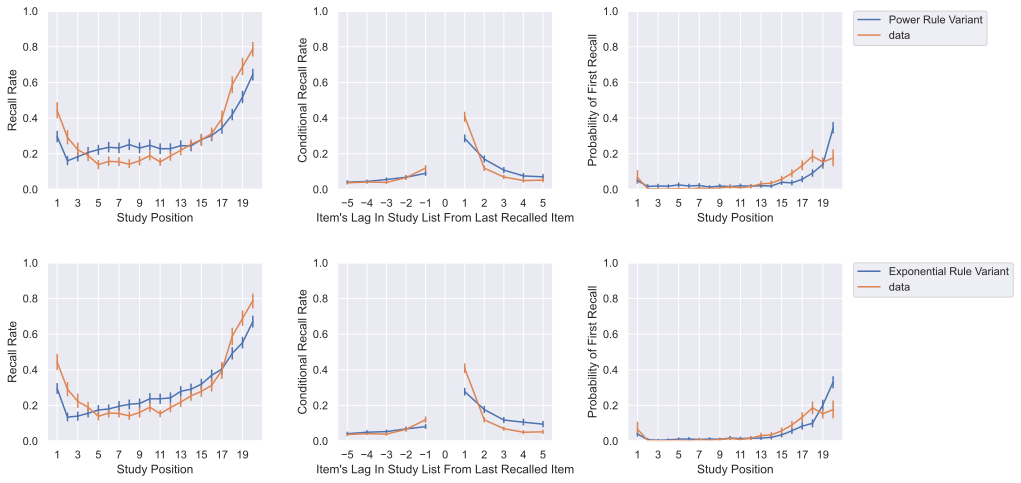

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15/2), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=power_cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, 21, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 0], data=exp_cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[1, 0].set_xticks(np.arange(1, 21, 2))
axes[1, 0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[0, 1], data=power_cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[0, 1], data=power_cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[0, 1].set_xticks(np.arange(-5, 6, 1))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=exp_cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=exp_cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

# pfr
sns.lineplot(data=power_cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[0, 2], hue='source')
axes[0, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[0, 2].set_xticks(np.arange(1, 21, 2))
axes[0, 2].set_ylim((0, 1))

sns.lineplot(data=exp_cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[1, 2], hue='source')
axes[1, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[1, 2].set_xticks(np.arange(1, 21, 2))
axes[1, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('sampling_rule_overall_murdock1970.pdf', bbox_inches='tight')

## Individual-Level Model Fitting

In [ ]:
subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
power_cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = cmr_murd_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count]]), 
        {'item_counts': List([murd_length0]), 'familiarity_scale': 0, 'sampling_rule': 0}, free_parameters)

    power_cmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(power_cmr_results[-1].fun)

0 0
296.5573009804489
1 20
244.27924025418147
2 40
336.60887327137567
3 60
344.275414489539
4 80
346.1126335984281
5 100
307.4928785893931
6 120
262.5009018805981
7 140
288.8342443643665
8 160
232.89300465262244
9 180
360.06801586572453
10 200
184.7650928911337
11 220
319.17973560444557
12 240
380.0200737553753
13 260
270.00675078350287
14 280
289.5525122101564
15 300
337.2247162724865
16 320
333.54826250299186
17 340
289.2731698640631
18 360
394.98803889909925
19 380
394.4118173134271
20 400
313.0327603271379
21 420
338.06779211195135
22 440
387.2715630553225
23 460
297.7611631563961
24 480
273.0998431583606
25 500
372.2551684605633
26 520
327.66822497234847
27 540
292.0739677649996
28 560
348.41927978385587
29 580
301.51782577614034
30 600
347.5912024705961
31 620
310.1710900359277
32 640
336.7327568176391
33 660
386.6765692360729
34 680
314.84810794333475
35 700
387.31223520131533
36 720
299.403269381128
37 740
298.65938548675103
38 760
237.84056959872686
39 780
233.83008531907288
4

In [ ]:
subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
exp_cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = cmr_murd_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count]]), 
        {'item_counts': List([murd_length0]), 'familiarity_scale': 0, 'sampling_rule': 1}, free_parameters)

    exp_cmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(exp_cmr_results[-1].fun)

0 0
296.0594739642418
1 20
239.9140423098181
2 40
337.5849423760319
3 60
344.3822543949824
4 80
343.02090645564783
5 100
305.82555531631914
6 120
264.5346212552107
7 140
289.02677152291466
8 160
234.16138333226635
9 180
355.8455040097493
10 200
182.69048661592555
11 220
315.8410890265486
12 240
373.74913901924987
13 260
268.6738997932775
14 280
288.3762280722613
15 300
336.35235442394065
16 320
312.1975441572923
17 340
287.405964274005
18 360
394.45531379424347
19 380
391.6798093680637
20 400
312.0675817065895
21 420
331.1128118815576
22 440
387.0469567256356
23 460
299.400319601785
24 480
272.0191236735642
25 500
369.0603721071784
26 520
327.84741087939557
27 540
291.07825399811367
28 560
348.2147277044099
29 580
300.7353195289586
30 600
340.0612390694199
31 620
307.5203238812499
32 640
336.8782810860426
33 660
384.8114092494432
34 680
313.1343553389606
35 700
389.3963604243623
36 720
297.73425914794916
37 740
297.59840527681433
38 760
237.6194871909267
39 780
234.78032915028268
40 80

In [ ]:
individual_fits = [result.fun for result in power_cmr_results] + [result.fun for result in exp_cmr_results]
labels = ['Power Rule'] * len(power_cmr_results) + ['Exponential Rule'] * len(exp_cmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

print(pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown())

|       |   Exponential Rule |   Power Rule |
|:------|-------------------:|-------------:|
| count |            72      |      72      |
| mean  |           297.988  |     299.435  |
| std   |            53.7617 |      54.2917 |
| min   |           155.208  |     154.257  |
| 25%   |           261.233  |     261.036  |
| 50%   |           299.379  |     299.031  |
| 75%   |           336.484  |     336.856  |
| max   |           394.455  |     394.988  |


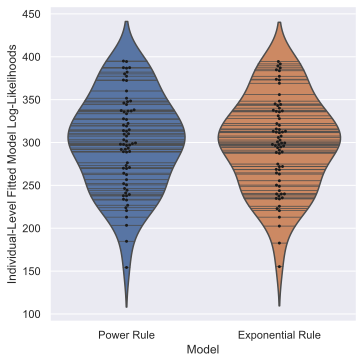

In [ ]:
sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
plt.savefig('individual_sampling_rules.pdf', bbox_inches="tight")

## Conclusion
Once you get the numerical overflow stuff out of the way (in retrospect, MATLAB seems to better handle this sort of issue) and fit the parameters, the models do about the same here. Still, there are some somewhat striking differences between the summary statistic lines here, even after fitting.